# Metallic Surface Defect Detection - Training Notebook

This notebook trains a deep learning model to classify metallic surface defects into 6 categories:
- Crazing
- Inclusion
- Patches
- Pitted
- Rolled
- Scratches

**For Google Colab:** Upload this notebook and your dataset folder to Google Drive, then mount the drive.

## 1. Setup and Installation

In [1]:
# Install required packages (if not already installed)
!pip install torch torchvision matplotlib seaborn scikit-learn pillow -q

In [2]:
# Mount Google Drive (for Colab)
# Uncomment the lines below if running on Google Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Import Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm import tqdm
import time
from PIL import Image

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.9.0+cu126
CUDA Available: True
CUDA Device: Tesla T4


## 3. Configuration and Hyperparameters

In [7]:
# ==================== CONFIGURATION ====================
# Update DATA_DIR path based on your setup:
# - For Local: './data'
# - For Colab: '/content/drive/MyDrive/your_folder_path/data'

DATA_DIR = '/content/drive/MyDrive/data'  # Update this path for Colab
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'valid')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Model Configuration
MODEL_NAME = 'resnet50'  # Options: resnet50, resnet101, efficientnet_b0, vgg16
NUM_CLASSES = 6
IMG_SIZE = 224

# Training Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Class names
CLASS_NAMES = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

print(f"\nDataset Directories:")
print(f"Train: {TRAIN_DIR}")
print(f"Valid: {VALID_DIR}")
print(f"Test: {TEST_DIR}")


Using device: cuda

Dataset Directories:
Train: /content/drive/MyDrive/data/train
Valid: /content/drive/MyDrive/data/valid
Test: /content/drive/MyDrive/data/test


## 4. Data Augmentation and Preprocessing

In [8]:
# Data transformations
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

print("Data transformations created successfully!")

Data transformations created successfully!


## 5. Load Datasets

In [9]:
# Load datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
valid_dataset = datasets.ImageFolder(VALID_DIR, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Dataset information
print(f"\nDataset Statistics:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"\nClass to Index Mapping: {train_dataset.class_to_idx}")
print(f"\nBatches per epoch (train): {len(train_loader)}")


Dataset Statistics:
Training samples: 1656
Validation samples: 72
Test samples: 72

Class to Index Mapping: {'Crazing': 0, 'Inclusion': 1, 'Patches': 2, 'Pitted': 3, 'Rolled': 4, 'Scratches': 5}

Batches per epoch (train): 52


## 6. Visualize Sample Images

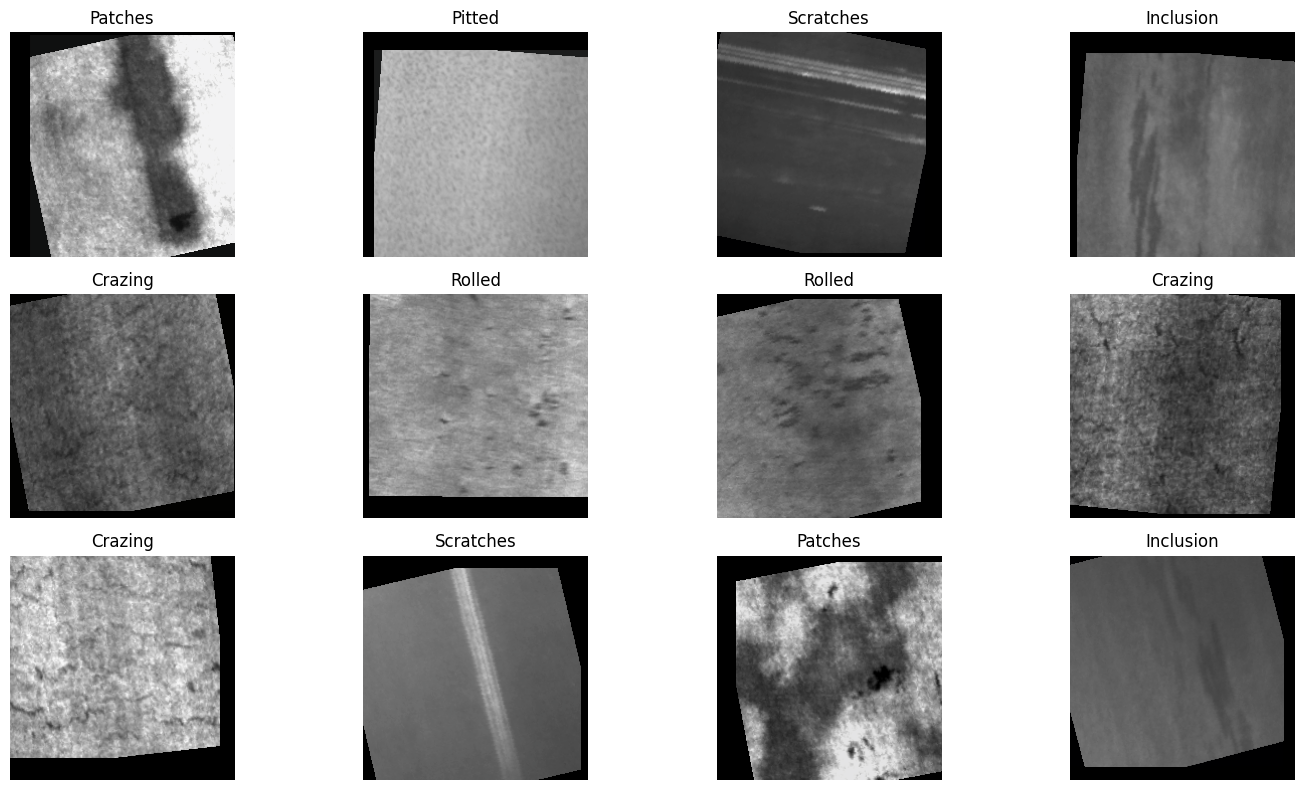

In [10]:
def imshow(img, title=None):
    """Display image with denormalization"""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot sample images
fig = plt.figure(figsize=(15, 8))
for idx in range(min(12, len(images))):
    ax = fig.add_subplot(3, 4, idx+1)
    imshow(images[idx])
    ax.set_title(f"{CLASS_NAMES[labels[idx]]}")
plt.tight_layout()
plt.show()

## 7. Model Architecture

In [11]:
def create_model(model_name, num_classes, pretrained=True):
    """
    Create a transfer learning model
    """
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'resnet101':
        model = models.resnet101(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=pretrained)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=pretrained)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)

    else:
        raise ValueError(f"Model {model_name} not supported")

    return model

# Create model
model = create_model(MODEL_NAME, NUM_CLASSES, pretrained=True)
model = model.to(device)

print(f"\nModel Architecture: {MODEL_NAME}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]



Model Architecture: resnet50
Total parameters: 23,520,326
Trainable parameters: 23,520,326


## 8. Loss Function and Optimizer

In [13]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(),
                     lr=LEARNING_RATE,
                     momentum=MOMENTUM,
                     weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='min',
                                                 factor=0.5,
                                                 patience=3)

print("Optimizer and scheduler initialized!")

Optimizer and scheduler initialized!


## 9. Training Functions

In [14]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train for one epoch
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(dataloader, desc='Training', leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc.item()


def validate_epoch(model, dataloader, criterion, device):
    """
    Validate for one epoch
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Validation', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc.item()

print("Training functions defined!")

Training functions defined!


## 10. Train the Model

In [15]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_model_weights = None

print("\n" + "="*60)
print("Starting Training...")
print("="*60)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate_epoch(model, valid_loader, criterion, device)

    # Update learning rate
    scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print statistics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_weights = model.state_dict().copy()
        print(f"✓ New best model saved! Val Acc: {best_val_acc:.4f}")

total_time = time.time() - start_time
print("\n" + "="*60)
print(f"Training Complete in {total_time//60:.0f}m {total_time%60:.0f}s")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print("="*60)

# Load best model weights
model.load_state_dict(best_model_weights)


Starting Training...

Epoch 1/25
----------------------------------------


Train Loss: 0.8974 | Train Acc: 0.7446
Val Loss: 0.0722 | Val Acc: 1.0000
✓ New best model saved! Val Acc: 1.0000

Epoch 2/25
----------------------------------------


Train Loss: 0.0868 | Train Acc: 0.9891
Val Loss: 0.0151 | Val Acc: 1.0000

Epoch 3/25
----------------------------------------


Train Loss: 0.0705 | Train Acc: 0.9843
Val Loss: 0.0045 | Val Acc: 1.0000

Epoch 4/25
----------------------------------------


Train Loss: 0.0392 | Train Acc: 0.9915
Val Loss: 0.0019 | Val Acc: 1.0000

Epoch 5/25
----------------------------------------


Train Loss: 0.0262 | Train Acc: 0.9958
Val Loss: 0.0014 | Val Acc: 1.0000

Epoch 6/25
----------------------------------------


Train Loss: 0.0233 | Train Acc: 0.9952
Val Loss: 0.0014 | Val Acc: 1.0000

Epoch 7/25
----------------------------------------


Train Loss: 0.0201 | Train Acc: 0.9952
Val Loss: 0.0010 | Val Acc: 1.0000

Epoch 8/25
----------------------------------------


Train Loss: 0.0280 | Train Acc: 0.9952
Val Loss: 0.0012 | Val Acc: 1.0000

Epoch 9/25
----------------------------------------


Train Loss: 0.0166 | Train Acc: 0.9964
Val Loss: 0.0005 | Val Acc: 1.0000

Epoch 10/25
----------------------------------------


Train Loss: 0.0079 | Train Acc: 0.9994
Val Loss: 0.0005 | Val Acc: 1.0000

Epoch 11/25
----------------------------------------


Train Loss: 0.0148 | Train Acc: 0.9964
Val Loss: 0.0005 | Val Acc: 1.0000

Epoch 12/25
----------------------------------------


Train Loss: 0.0163 | Train Acc: 0.9964
Val Loss: 0.0003 | Val Acc: 1.0000

Epoch 13/25
----------------------------------------


Train Loss: 0.0139 | Train Acc: 0.9964
Val Loss: 0.0004 | Val Acc: 1.0000

Epoch 14/25
----------------------------------------


Train Loss: 0.0077 | Train Acc: 0.9994
Val Loss: 0.0003 | Val Acc: 1.0000

Epoch 15/25
----------------------------------------


Train Loss: 0.0110 | Train Acc: 0.9958
Val Loss: 0.0003 | Val Acc: 1.0000

Epoch 16/25
----------------------------------------


Train Loss: 0.0098 | Train Acc: 0.9988
Val Loss: 0.0002 | Val Acc: 1.0000

Epoch 17/25
----------------------------------------


Train Loss: 0.0040 | Train Acc: 0.9994
Val Loss: 0.0002 | Val Acc: 1.0000

Epoch 18/25
----------------------------------------


Train Loss: 0.0064 | Train Acc: 0.9982
Val Loss: 0.0002 | Val Acc: 1.0000

Epoch 19/25
----------------------------------------


Train Loss: 0.0094 | Train Acc: 0.9976
Val Loss: 0.0002 | Val Acc: 1.0000

Epoch 20/25
----------------------------------------


Train Loss: 0.0051 | Train Acc: 0.9994
Val Loss: 0.0001 | Val Acc: 1.0000

Epoch 21/25
----------------------------------------


Train Loss: 0.0031 | Train Acc: 1.0000
Val Loss: 0.0001 | Val Acc: 1.0000

Epoch 22/25
----------------------------------------


Train Loss: 0.0064 | Train Acc: 0.9976
Val Loss: 0.0002 | Val Acc: 1.0000

Epoch 23/25
----------------------------------------


Train Loss: 0.0044 | Train Acc: 0.9988
Val Loss: 0.0001 | Val Acc: 1.0000

Epoch 24/25
----------------------------------------


Train Loss: 0.0057 | Train Acc: 0.9988
Val Loss: 0.0001 | Val Acc: 1.0000

Epoch 25/25
----------------------------------------


Train Loss: 0.0047 | Train Acc: 0.9994
Val Loss: 0.0001 | Val Acc: 1.0000

Training Complete in 11m 43s
Best Validation Accuracy: 1.0000


<All keys matched successfully>

## 11. Plot Training History

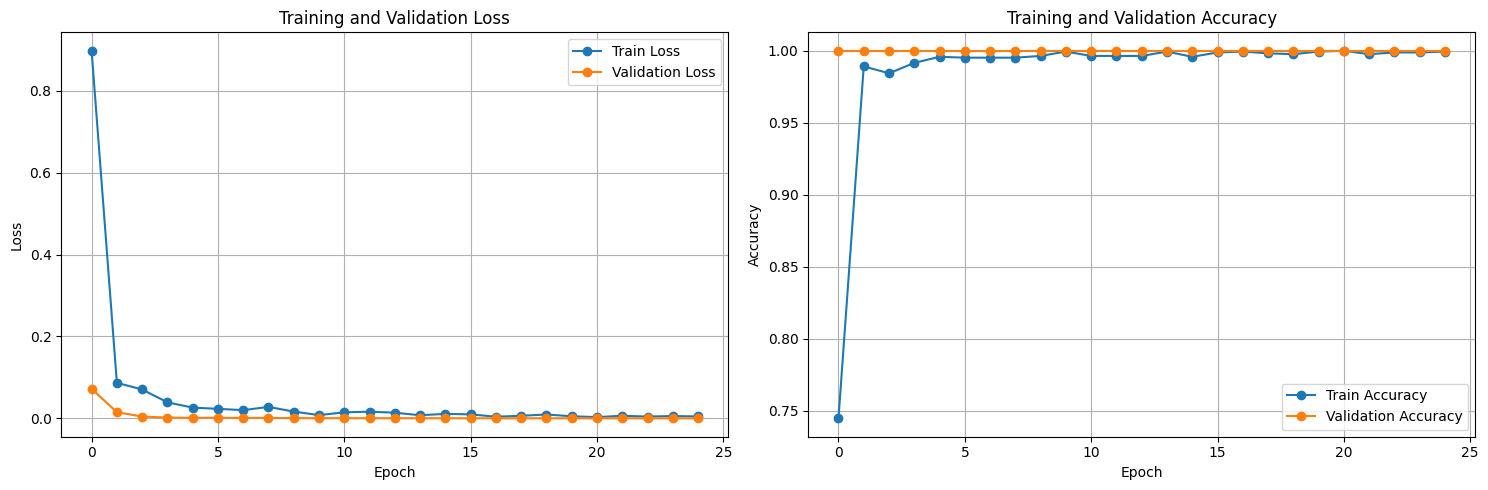

Training history plots saved!


In [16]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Validation Accuracy', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plots saved!")

## 12. Evaluate on Test Set

In [17]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate model and return predictions and labels
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Evaluate on test set
print("\nEvaluating on test set...")
test_preds, test_labels, test_probs = evaluate_model(model, test_loader, device)

# Calculate accuracy
test_accuracy = (test_preds == test_labels).mean()
print(f"\nTest Accuracy: {test_accuracy:.4f}")


Evaluating on test set...


Testing: 100%|██████████| 3/3 [00:15<00:00,  5.02s/it]


Test Accuracy: 1.0000


## 13. Classification Report

In [18]:
# Classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(test_labels, test_preds, target_names=CLASS_NAMES))


Classification Report:
              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       1.00      1.00      1.00        12
     Patches       1.00      1.00      1.00        12
      Pitted       1.00      1.00      1.00        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      1.00      1.00        12

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



## 14. Confusion Matrix

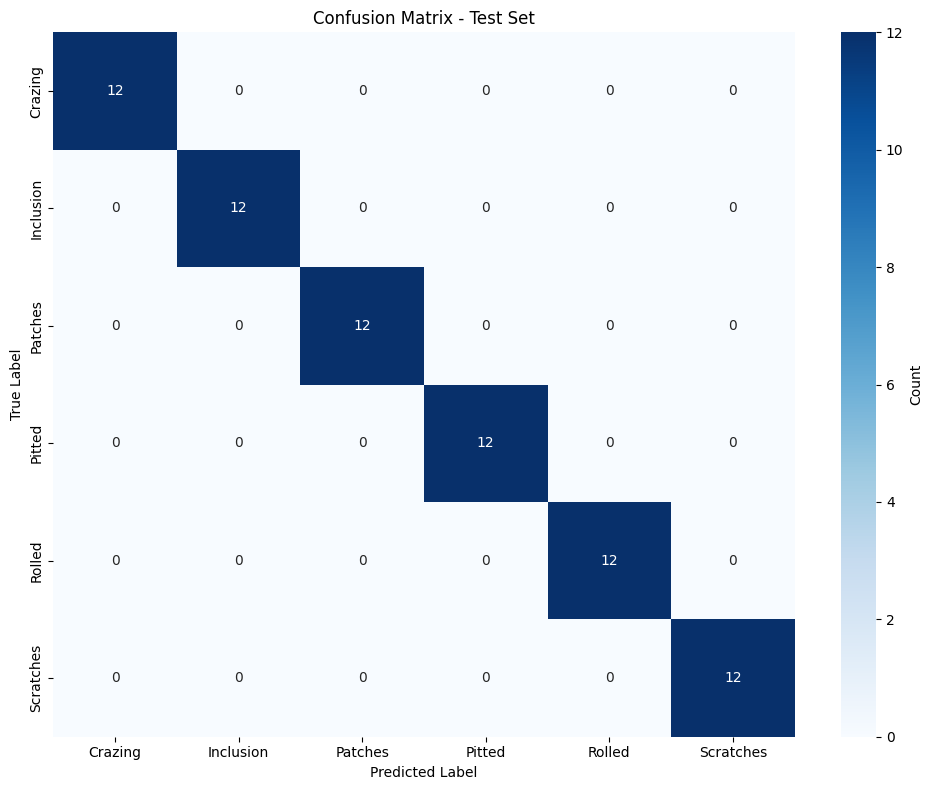

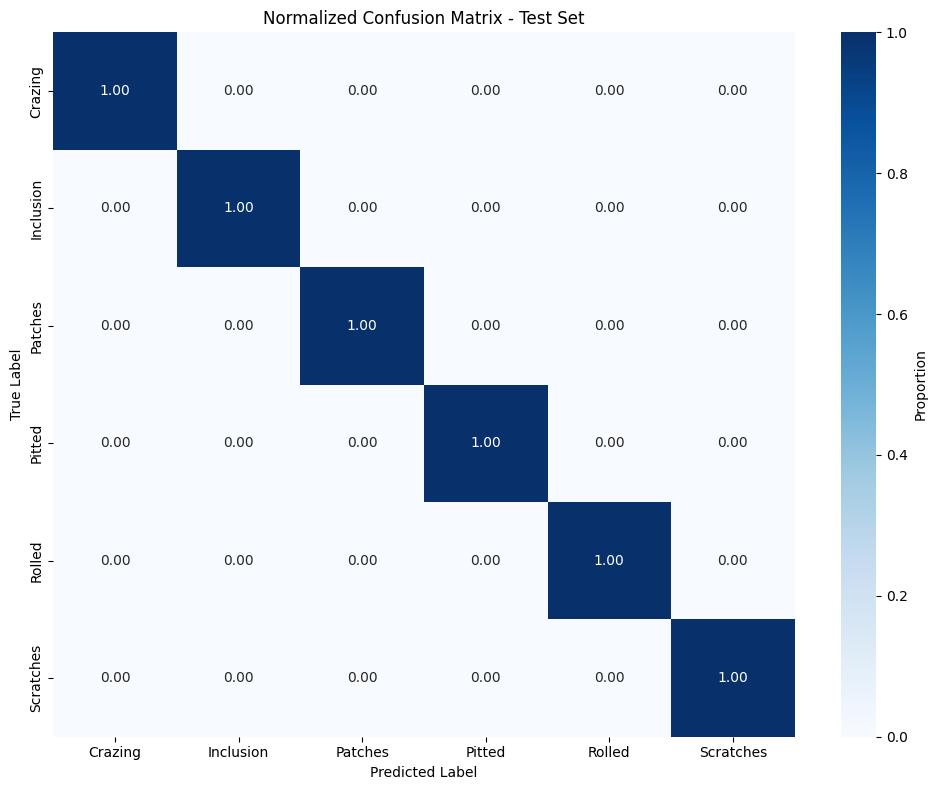

In [19]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Proportion'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix - Test Set')
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

## 15. Visualize Predictions

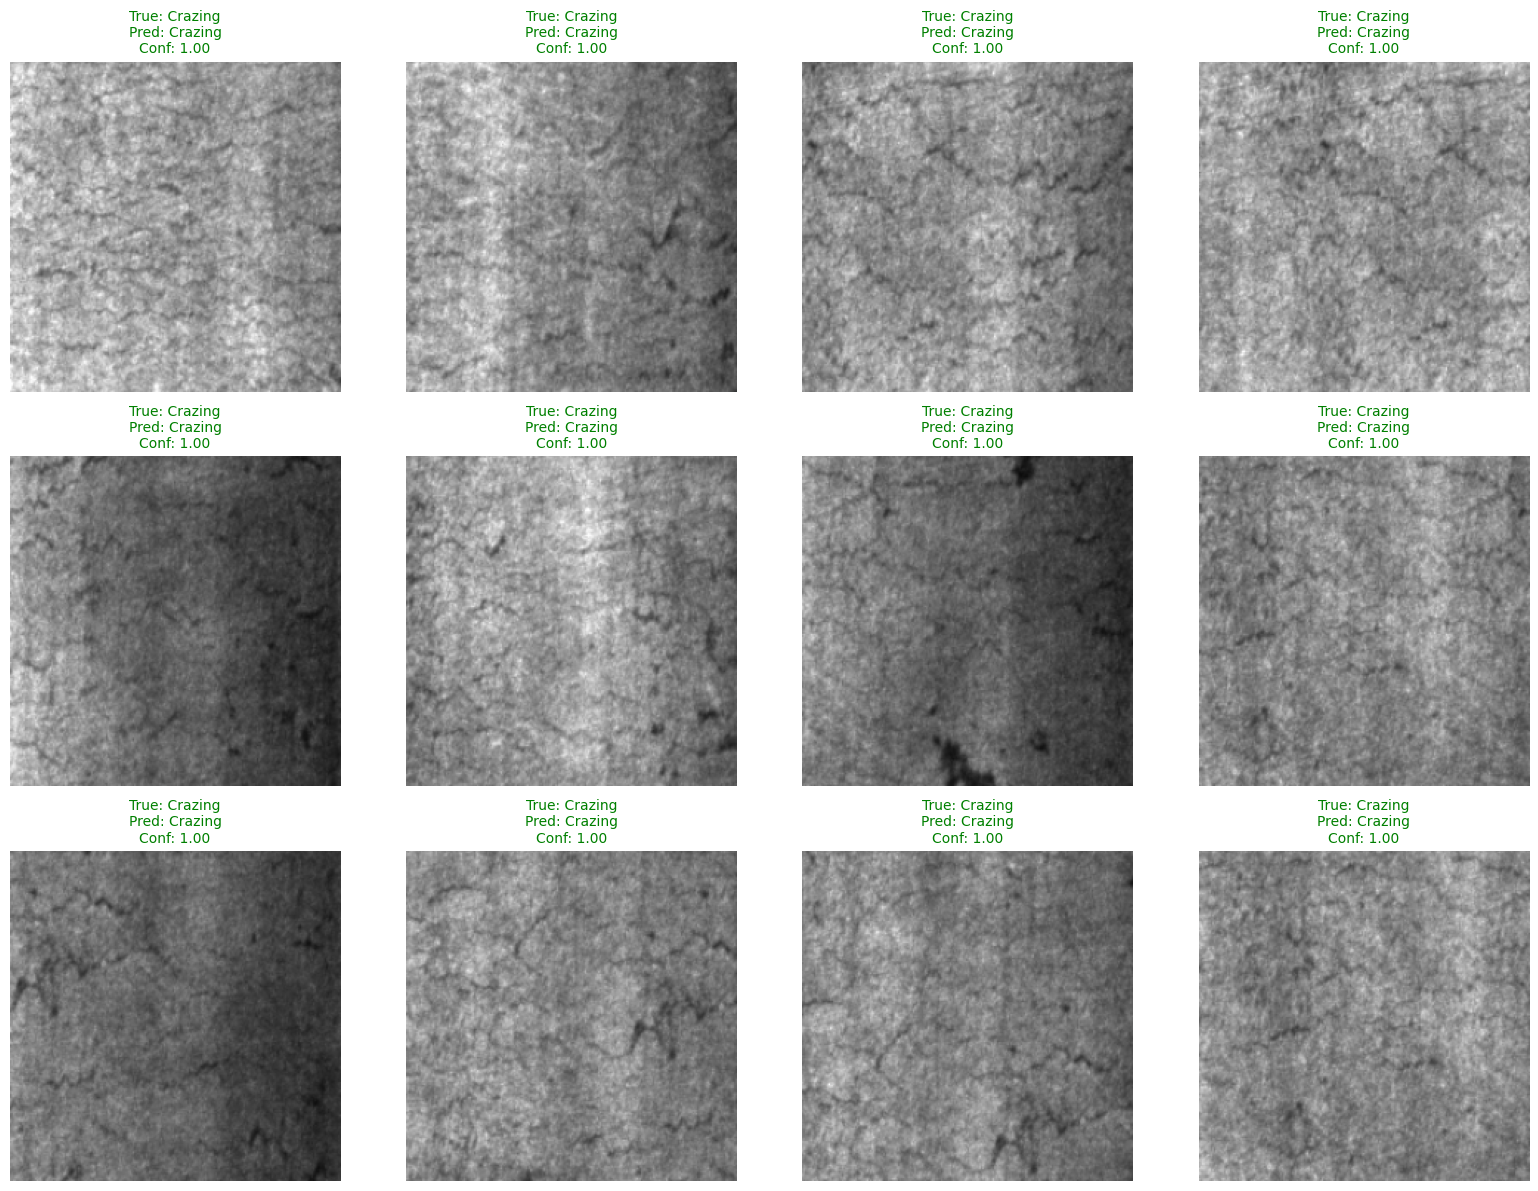

In [20]:
# Visualize some test predictions
def visualize_predictions(model, dataloader, device, num_images=12):
    model.eval()
    images_shown = 0

    fig = plt.figure(figsize=(16, 12))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    break

                ax = fig.add_subplot(3, 4, images_shown + 1)

                # Denormalize and display image
                img = inputs[i].cpu()
                imshow(img)

                pred_label = CLASS_NAMES[preds[i]]
                true_label = CLASS_NAMES[labels[i]]
                confidence = probs[i][preds[i]].item()

                color = 'green' if preds[i] == labels[i] else 'red'
                ax.set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}",
                           color=color, fontsize=10)

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions(model, test_loader, device, num_images=12)

## 16. Save the Trained Model

In [21]:
# Save the complete model
MODEL_SAVE_PATH = 'defect_detection_model.pth'

# Save model state dict
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_acc': best_val_acc,
    'class_names': CLASS_NAMES,
    'model_name': MODEL_NAME,
    'img_size': IMG_SIZE
}, MODEL_SAVE_PATH)

print(f"\n✓ Model saved to: {MODEL_SAVE_PATH}")

# Also save as TorchScript for deployment
model.eval()
example_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
traced_model = torch.jit.trace(model, example_input)
traced_model.save('defect_detection_model_scripted.pt')

print("✓ TorchScript model saved to: defect_detection_model_scripted.pt")


✓ Model saved to: defect_detection_model.pth
✓ TorchScript model saved to: defect_detection_model_scripted.pt


## 17. Inference Function for Single Image

In [22]:
def predict_single_image(model, image_path, transform, device, class_names):
    """
    Predict defect class for a single image
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)

    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()

    # Get all class probabilities
    all_probs = probs[0].cpu().numpy()

    return predicted_class, confidence_score, all_probs

print("\nInference function ready!")
print("\nExample usage:")
print("predicted_class, confidence, probs = predict_single_image(")
print("    model, 'path/to/image.jpg', val_test_transforms, device, CLASS_NAMES)")
print("print(f'Predicted: {predicted_class} with confidence: {confidence:.2f}')")


Inference function ready!

Example usage:
predicted_class, confidence, probs = predict_single_image(
    model, 'path/to/image.jpg', val_test_transforms, device, CLASS_NAMES)
print(f'Predicted: {predicted_class} with confidence: {confidence:.2f}')


## 18. Summary and Next Steps

In [23]:
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Model: {MODEL_NAME}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Classes: {', '.join(CLASS_NAMES)}")
print(f"\nDataset Sizes:")
print(f"  - Training: {len(train_dataset)} images")
print(f"  - Validation: {len(valid_dataset)} images")
print(f"  - Test: {len(test_dataset)} images")
print(f"\nTraining Configuration:")
print(f"  - Epochs: {NUM_EPOCHS}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"\nResults:")
print(f"  - Best Validation Accuracy: {best_val_acc:.4f}")
print(f"  - Test Accuracy: {test_accuracy:.4f}")
print(f"\nSaved Files:")
print(f"  - Model: {MODEL_SAVE_PATH}")
print(f"  - TorchScript: defect_detection_model_scripted.pt")
print(f"  - Training History: training_history.png")
print(f"  - Confusion Matrix: confusion_matrix.png")
print(f"  - Sample Predictions: sample_predictions.png")
print("="*60)
print("\nNext Steps:")
print("1. Download the trained model (.pth file)")
print("2. Use the model for inference on new images")
print("3. Deploy the model in a web application")
print("4. Fine-tune with more data if needed")
print("="*60)


TRAINING SUMMARY
Model: resnet50
Number of Classes: 6
Classes: Crazing, Inclusion, Patches, Pitted, Rolled, Scratches

Dataset Sizes:
  - Training: 1656 images
  - Validation: 72 images
  - Test: 72 images

Training Configuration:
  - Epochs: 25
  - Batch Size: 32
  - Learning Rate: 0.001
  - Image Size: 224x224

Results:
  - Best Validation Accuracy: 1.0000
  - Test Accuracy: 1.0000

Saved Files:
  - Model: defect_detection_model.pth
  - TorchScript: defect_detection_model_scripted.pt
  - Training History: training_history.png
  - Confusion Matrix: confusion_matrix.png
  - Sample Predictions: sample_predictions.png

Next Steps:
1. Download the trained model (.pth file)
2. Use the model for inference on new images
3. Deploy the model in a web application
4. Fine-tune with more data if needed
